In [1]:
#pip install pandahouse
import pandahouse as ph
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
connection_default = {'host': 'http://clickhouse.beslan.pro:8080',
'database':'default',
'user':'student',
'password':'dpo_python_2020'
}

In [3]:
connection_test = dict(database='default',
host='http://clickhouse.beslan.pro:8080',
user='student-rw',
password='656e2b0c9c')

Для начала, проверим правильность подключения к ClickHouse через pandahouse, отправив простой запрос: выведите количество строк в таблице ldn_listings.

In [12]:
q = '''
SELECT
count(id) AS count_rows
FROM
{db}.ldn_listings
'''
q_count = ph.read_clickhouse(query=q, connection=connection_default)
q_count

,count_rows
0,85207


Сгруппируйте полученный датафрейм по типу жилья и посчитайте 75-й перцентиль  цены.
В качестве ответа впишите полученное значение 75 перцентиля цены для комнат типа Private room.

In [14]:
q2 = '''
SELECT 
    quantile(0.75)(price), room_type
FROM (SELECT  id,
        room_type,
        toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price
FROM {db}.ldn_listings
ORDER BY
    id ASC
LIMIT 1000) AS df
GROUP by
    room_type
'''
q_room = ph.read_clickhouse(query=q2, connection=connection_default)
q_room

,quantile(0.75)(price),room_type
0,157.00,Hotel room
1,70.00,Private room
2,69.25,Shared room
3,160.00,Entire home/apt


In [16]:
q3 = '''
SELECT  
    room_type,
    AVG(toFloat32OrNull(replaceRegexpAll(price, '[$,]', ''))) AS avg_price,
    AVG(toFloat32OrNull(replaceRegexpAll(review_scores_rating, '[$,]', ''))) AS avg_review_scores_rating
FROM default.ldn_listings
GROUP by
    room_type
'''
q_room_3 = ph.read_clickhouse(query=q3, connection=connection_default)
q_room_3

,room_type,avg_price,avg_review_scores_rating
0,Hotel room,357.625984,85.786458
1,Private room,63.332954,93.156013
2,Shared room,125.076809,87.198847
3,Entire home/apt,174.837720,92.301768


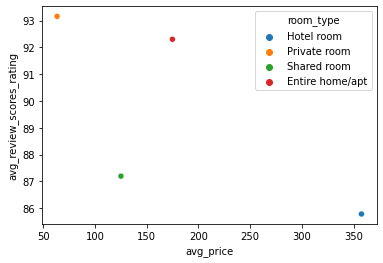

In [21]:
sns.scatterplot(data=q_room_3, x='avg_price', y='avg_review_scores_rating', hue='room_type')

Используйте методы explode и value_counts, чтобы посчитать, сколько раз встречается каждый способ верификации
Сколько хозяев подтвердили профиль с помощью аккаунта Google?

In [96]:
q4 = '''
SELECT 
    DISTINCT host_id, 
    host_verifications
FROM default.ldn_listings
WHERE
    experiences_offered !='none'
'''
q_room_4 = ph.read_clickhouse(query=q4, connection=connection_default)
q_room_4

,host_id,host_verifications
0,54730,"['email', 'phone', 'facebook', 'reviews', 'off..."
1,60302,"['email', 'phone', 'reviews', 'jumio', 'govern..."
2,67915,"['email', 'phone', 'jumio', 'selfie', 'governm..."
3,167107,"['email', 'phone', 'manual_offline', 'jumio', ..."
4,103583,"['email', 'phone', 'reviews', 'offline_governm..."
...,...,...
1356,21558962,"['email', 'phone', 'reviews', 'jumio', 'govern..."
1357,21257846,"['email', 'phone', 'reviews', 'jumio', 'offlin..."
1358,34219613,"['email', 'phone', 'reviews', 'jumio', 'govern..."
1359,34299581,"['email', 'phone', 'google', 'reviews', 'jumio..."


In [97]:
q_room_4['host_verifications'] = q_room_4['host_verifications'].apply(lambda x: pd.eval(x))

In [98]:
q_room_4.host_verifications[0]

['email',
 'phone',
 'facebook',
 'reviews',
 'offline_government_id',
 'selfie',
 'government_id']

In [99]:
q_room_4.explode('host_verifications').host_verifications.value_counts().to_frame(name='count')

,count
phone,1361
email,1345
reviews,1309
government_id,1196
jumio,1115
offline_government_id,469
work_email,279
facebook,270
selfie,252
identity_manual,227


Теперь посмотрим, для скольких объявлений и в каких районах хозяева указали впечатления. Сгруппируйте данные по району и виду впечатления и посчитайте количество объявлений. Новый столбец назовите experiences_count.Отсортируйте данные по убыванию experiences_count и выгрузите первые 100 строк. Затем преобразуйте данные с помощью pivot, поместив в индексы название района, столбцы – вид впечатления, а значения – число объявлений с таким впечатлением для каждого района. Визуализируйте результат с помощью sns.heatmap() c палитрой cmap=sns.cubehelix_palette(as_cmap=True). 

In [100]:
q5 = '''
SELECT
    neighbourhood_cleansed,
    experiences_offered,
    COUNT(experiences_offered )AS experiences_count
FROM default.ldn_listings
WHERE
    experiences_offered != 'none'
GROUP BY
    neighbourhood_cleansed, experiences_offered
ORDER BY
    experiences_count DESC
LIMIT 100
'''
q_room_5 = ph.read_clickhouse(query=q5, connection=connection_default)
q_room_5

,neighbourhood_cleansed,experiences_offered,experiences_count
0,Hackney,family,61
1,Tower Hamlets,business,58
2,Westminster,business,50
3,Hackney,social,49
4,Hammersmith and Fulham,business,48
...,...,...,...
95,Redbridge,social,2
96,Barking and Dagenham,social,2
97,Newham,romantic,1
98,Bexley,business,1


In [102]:
q_room_5_final = q_room_5.pivot(index='neighbourhood_cleansed', columns='experiences_offered', values='experiences_count')

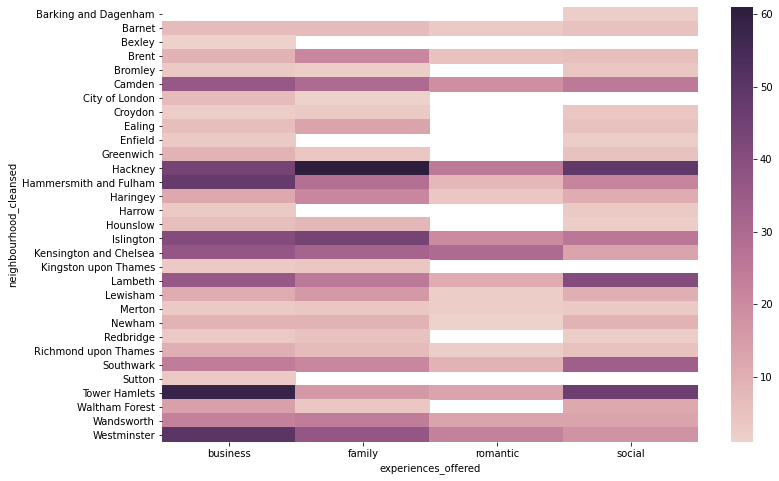

In [120]:
plt.figure(figsize=(12, 8))
sns.heatmap(q_room_5_final, cmap=sns.cubehelix_palette(as_cmap=True))

Выгрузите данные о ценах за ночь для разных типов жилья, для которых также доступен какой-либо вид впечатления. Необходимые для составления запроса столбцы:
room_type – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)
price – цена за ночь 
experiences_offered – вид доступного впечатления (оставить не 'none')
Далее постройте два графика, используя distplot из библиотеки seaborn:
На первом отобразите исходные распределения цен для каждого типа жилья
На втором – логарифмированные значения (np.log())

In [14]:
q6 = '''
SELECT  
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price
FROM default.ldn_listings
WHERE
    experiences_offered != 'none'
'''
q_room_6 = ph.read_clickhouse(query=q6, connection=connection_default)
q_room_6

,room_type,price
0,Private room,65.0
1,Entire home/apt,100.0
2,Private room,150.0
3,Private room,45.0
4,Private room,25.0
...,...,...
1543,Entire home/apt,100.0
1544,Entire home/apt,125.0
1545,Entire home/apt,185.0
1546,Entire home/apt,110.0


<Figure size 1008x720 with 0 Axes>

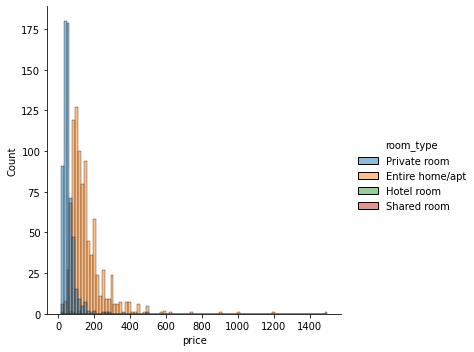

In [25]:
plt.figure(figsize=(12, 8))
sns.displot(data=q_room_6, x="price", hue="room_type", kde=False)

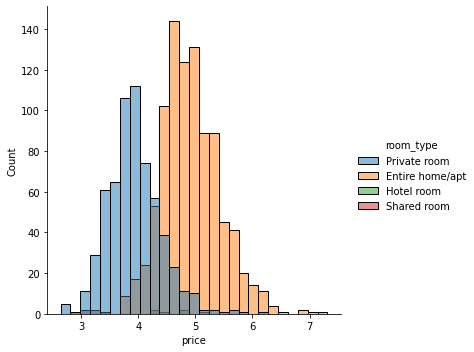

In [22]:
sns.displot(data=q_room_6, x=np.log(q_room_6.price), hue="room_type", kde=False)

Выгрузите данные о цене, типе жилья и дате первого отзыва, начиная со 2 января 2010 года. Необходимые столбцы:
room_type – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)
price – цена за ночь
first_review – дата первого отзыва (отфильтровать по правилу "строго больше 2010-01-01")
Ограничение поставьте на 1000 строк.
Используя библиотеку seaborn и функцию lineplot, постройте график динамики средних цен на жилье (ось Y) 
в зависимости от типа комнаты (цвет линии, параметр 'hue') по годам (ось X). 
Датафрейм должен быть отсортирован по годам.

In [84]:
q7 = '''
SELECT first_review, 
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price, 
    room_type
FROM default.ldn_listings
WHERE 
    first_review > '2010-01-01'
LIMIT 1000
'''
q_room_7 = ph.read_clickhouse(query=q7, connection=connection_default)
q_room_7

,first_review,price,room_type
0,2010-08-18,65.0,Private room
1,2011-03-21,300.0,Entire home/apt
2,2016-03-05,65.0,Entire home/apt
3,2010-04-14,29.0,Private room
4,2010-10-16,100.0,Private room
...,...,...,...
995,2012-11-07,45.0,Private room
996,2013-03-18,51.0,Private room
997,2012-09-17,79.0,Entire home/apt
998,2012-09-24,110.0,Entire home/apt


In [85]:
q_room_7['first_review'] = q_room_7.first_review.apply(lambda x: str(x)[:-6])

In [86]:
q_room_7.head(10)

,first_review,price,room_type
0,2010,65.0,Private room
1,2011,300.0,Entire home/apt
2,2016,65.0,Entire home/apt
3,2010,29.0,Private room
4,2010,100.0,Private room
5,2010,195.0,Entire home/apt
6,2010,72.0,Private room
7,2010,80.0,Entire home/apt
8,2010,70.0,Private room
9,2010,65.0,Entire home/apt


In [87]:
q_room_8 = q_room_7.groupby(['room_type', 'first_review'], as_index=False) \
        .agg({'price': 'mean'}) \
        .rename(columns={'price': 'avg_price'}) \
        .rename(columns={'first_review': 'year'})

In [88]:
q_room_8.head(10)

,room_type,year,avg_price
0,Entire home/apt,2010,103.500000
1,Entire home/apt,2011,128.792450
2,Entire home/apt,2012,135.467255
3,Entire home/apt,2013,137.887634
4,Entire home/apt,2014,154.583328
5,Entire home/apt,2015,159.380951
6,Entire home/apt,2016,99.733330
7,Entire home/apt,2017,111.666664
8,Entire home/apt,2018,125.066666
9,Entire home/apt,2019,301.666656


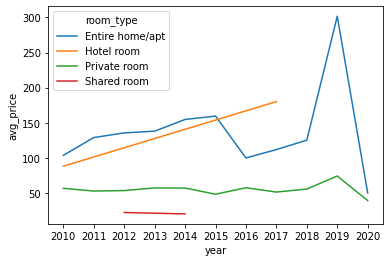

In [89]:
sns.lineplot(x='year', y='avg_price', hue='room_type', 
            data=q_room_8)